In [1]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [5]:
main_dir = "C:/ComputerVision/Data"
train_dataset_dir = main_dir + "/train"
test_dataset_dir = main_dir + "/test"

In [3]:
# Check if GPUs are available for training 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [6]:
# Define image dimensions and batch size
img_height = 32
img_width = 32
batch_size = 64

# Load the training data
train_ds_full = tf.keras.utils.image_dataset_from_directory(
    train_dataset_dir,
    seed=512,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Split train into train and validation
train_size = int(0.8 * len(train_ds_full))
val_size = len(train_ds_full) - train_size
train_ds = train_ds_full.take(train_size)
val_ds = train_ds_full.skip(train_size)

# Load the test data
val_ds_test = tf.keras.utils.image_dataset_from_directory(
    test_dataset_dir,
    seed=512,
    image_size=(img_height, img_width),
    batch_size=batch_size)

print("Training Classes:")
class_names = train_ds_full.class_names
print(class_names)

print("Testing Classes:")
print(val_ds_test.class_names)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Training Classes:
['FAKE', 'REAL']
Testing Classes:
['FAKE', 'REAL']


In [7]:
num_classes = 2

In [8]:
# Load Pre-trained MobileNetV3 Model
MobileNet_base_model = tf.keras.applications.MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Unfreeze the bottom block (e.g., last 20 layers)
for layer in MobileNet_base_model.layers[-20:]:
    layer.trainable = True

# Add classification head
x = GlobalAveragePooling2D()(MobileNet_base_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

# Create the full model
MobileNet_model = Model(inputs=MobileNet_base_model.input, outputs=output_layer)

# Compile the model
MobileNet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

C:\Users\mshrv\AppData\Roaming\Python\Python312\site-packages\keras\src\applications\mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [10]:
MobileNet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 32, 32, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 32, 32, 3)         │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv (Conv2D)                 │ (None, 16, 16, 16)        │             432 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_bn (BatchNormalization)  │ (None, 16, 16, 16)        │              64 │ conv[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 16, 16, 16)        │               0 │ conv_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_pad   │ (None, 17, 17, 16)        │               0 │ activation[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 8, 8, 16)          │             144 │ expanded_conv_depthwise_p… │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_bn    │ (None, 8, 8, 16)          │              64 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu (ReLU)                  │ (None, 8, 8, 16)          │               0 │ expanded_conv_depthwise_b… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_squeeze_excite… │ (None, 1, 1, 16)          │               0 │ re_lu[0][0]                │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_squeeze_excite… │ (None, 1, 1, 8)           │             136 │ expanded_conv_squeeze_exc… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_squeeze_excite… │ (None, 1, 1, 8)           │               0 │ expanded_conv_squeeze_exc… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_squeeze_excite… │ (None, 1, 1, 16)          │             144 │ expanded_conv_squeeze_exc… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 1, 1, 16)          │               

 Total params: 1,087,346 (4.15 MB)

 Trainable params: 1,075,234 (4.10 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [9]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

In [12]:
# Train the model
history = MobileNet_model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=20,
                    verbose = 1,
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.6070 - loss: 1.1281

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 243s 194ms/step - accuracy: 0.6070 - loss: 1.1279 - val_accuracy: 0.7649 - val_loss: 0.5078 - learning_rate: 1.0000e-04
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7072 - loss: 0.5930

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 150s 120ms/step - accuracy: 0.7072 - loss: 0.5929 - val_accuracy: 0.8094 - val_loss: 0.4259 - learning_rate: 1.0000e-04
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7734 - loss: 0.4829

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 152s 121ms/step - accuracy: 0.7734 - loss: 0.4829 - val_accuracy: 0.8379 - val_loss: 0.3699 - learning_rate: 1.0000e-04
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8213 - loss: 0.4026

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 150s 120ms/step - accuracy: 0.8213 - loss: 0.4026 - val_accuracy: 0.8600 - val_loss: 0.3225 - learning_rate: 1.0000e-04
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8509 - loss: 0.3455

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 150s 120ms/step - accuracy: 0.8509 - loss: 0.3455 - val_accuracy: 0.8803 - val_loss: 0.2872 - learning_rate: 1.0000e-04
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8733 - loss: 0.3060

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 148s 118ms/step - accuracy: 0.8733 - loss: 0.3060 - val_accuracy: 0.8929 - val_loss: 0.2574 - learning_rate: 1.0000e-04
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8892 - loss: 0.2686

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 149s 119ms/step - accuracy: 0.8892 - loss: 0.2686 - val_accuracy: 0.9039 - val_loss: 0.2355 - learning_rate: 1.0000e-04
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9026 - loss: 0.2394

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 150s 120ms/step - accuracy: 0.9026 - loss: 0.2394 - val_accuracy: 0.9118 - val_loss: 0.2165 - learning_rate: 1.0000e-04
Epoch 9/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9143 - loss: 0.2153

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 149s 119ms/step - accuracy: 0.9143 - loss: 0.2153 - val_accuracy: 0.9188 - val_loss: 0.2015 - learning_rate: 1.0000e-04
Epoch 10/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9238 - loss: 0.1906

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 148s 119ms/step - accuracy: 0.9238 - loss: 0.1906 - val_accuracy: 0.9250 - val_loss: 0.1915 - learning_rate: 1.0000e-04
Epoch 11/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9354 - loss: 0.1671

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 151s 121ms/step - accuracy: 0.9354 - loss: 0.1671 - val_accuracy: 0.9273 - val_loss: 0.1843 - learning_rate: 1.0000e-04
Epoch 12/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9378 - loss: 0.1561

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 151s 121ms/step - accuracy: 0.9378 - loss: 0.1561 - val_accuracy: 0.9304 - val_loss: 0.1816 - learning_rate: 1.0000e-04
Epoch 13/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9450 - loss: 0.1432

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 151s 120ms/step - accuracy: 0.9450 - loss: 0.1432 - val_accuracy: 0.9338 - val_loss: 0.1753 - learning_rate: 1.0000e-04
Epoch 14/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 148s 118ms/step - accuracy: 0.9496 - loss: 0.1284 - val_accuracy: 0.9354 - val_loss: 0.1772 - learning_rate: 1.0000e-04
Epoch 15/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9542 - loss: 0.1157

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 150s 120ms/step - accuracy: 0.9542 - loss: 0.1157 - val_accuracy: 0.9366 - val_loss: 0.1738 - learning_rate: 1.0000e-04
Epoch 16/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 149s 119ms/step - accuracy: 0.9579 - loss: 0.1083 - val_accuracy: 0.9356 - val_loss: 0.1829 - learning_rate: 1.0000e-04
Epoch 17/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 149s 119ms/step - accuracy: 0.9610 - loss: 0.0994 - val_accuracy: 0.9384 - val_loss: 0.1807 - learning_rate: 1.0000e-04
Epoch 18/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 149s 119ms/step - accuracy: 0.9654 - loss: 0.0893 - val_accuracy: 0.9378 - val_loss: 0.1842 - learning_rate: 1.0000e-04
Epoch 19/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 150s 120ms/step - accuracy: 0.9675 - loss: 0.0824 - val_accuracy: 0.9395 - val_loss: 0.1875 - learning_rate: 5.0000e-05
Epoch 20/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 150s 120ms/step - accuracy: 0.9729 - loss: 0.0698 - val_accuracy: 0.9391 - val_loss: 0.1964 - learning_rate: 5.0000e-05


In [17]:
# Evaluate the model
y_true = []
y_pred = []
y_scores = []

for images, labels in val_ds_test:
    preds = MobileNet_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))
    y_scores.extend(preds[:, 1])  # Assuming binary classification

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━

In [14]:
MobileNet_model.save("MobiletNet_model_modified.keras")

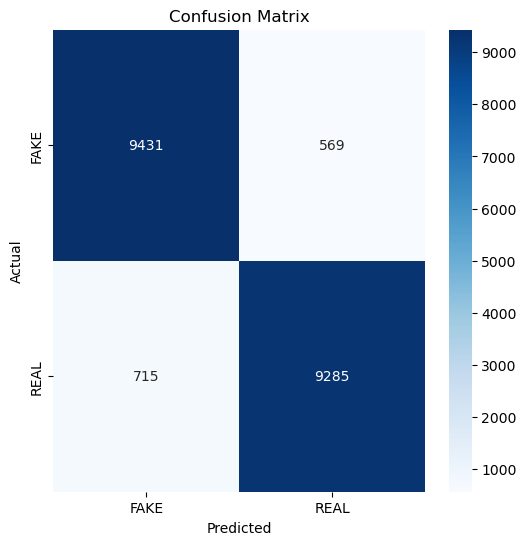

In [18]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Compute classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.93      0.94      0.94     10000
        REAL       0.94      0.93      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



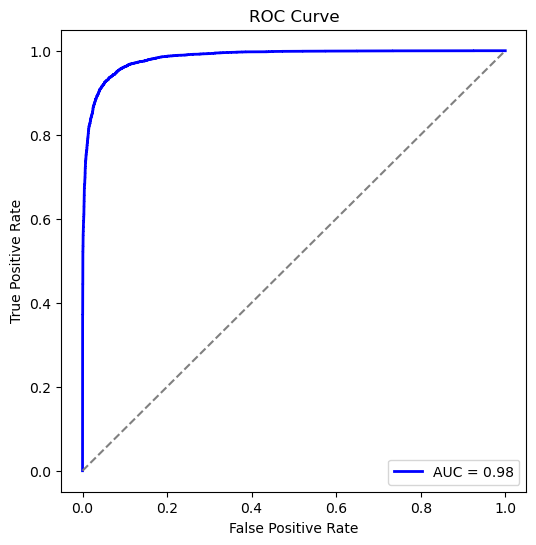

In [20]:
# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [21]:
# Print metrics
accuracy = np.mean(np.array(y_true) == np.array(y_pred))
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {roc_auc:.4f}")

Accuracy: 0.9358
AUC: 0.9844


In [18]:
model.save('Pure_MobileNet.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
